In [1]:
import numpy as np
from fft_tdse.simulator import *
from fft_tdse.animator import *
import matplotlib.pyplot as plt


In [37]:

x_min = -25
x_max = 25
r0 = 11
r1 = 25
ell = 0.111803

t_final = 100.0
dt = 0.01
mask_interval = 10


dim = 4
if dim == 2:
    nx = 512
elif dim == 3:
    nx = 128
elif dim == 4:
    nx = 64
    dt = 0.025
    


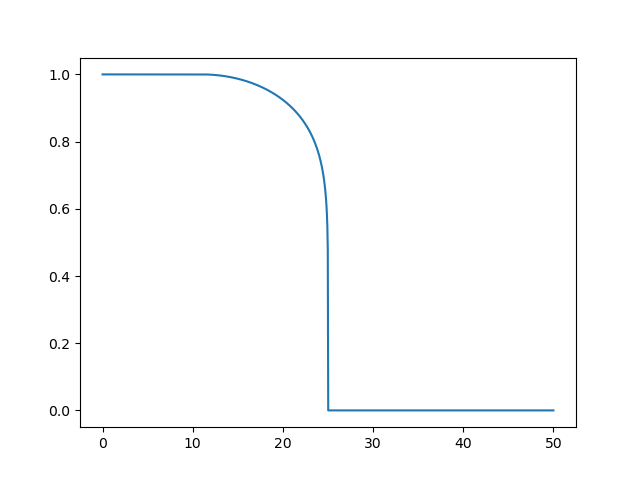

In [38]:

def potential2(x, y, ell=ell):
    return 0.5*(x**2 + y**2) + ell*(x**2*y - y**3/3)

def potential3(x, y, z, ell=ell):
    return 0.5*(x**2 + y**2 + z**2) + ell*(x**2*y - y**3/3 + y**2*z - z**3/3)

def potential4(x, y, z, w, ell=ell):
    return 0.5*(x**2 + y**2 + z**2 + w**2) + ell*(x**2*y - y**3/3 + y**2*z - z**3/3 + z**2*w - w**3/3)

def initial_condition2(x, y):
    # normalized gaussian
    return np.exp(-0.5*((x-2)**2 + (y-2)**2)) / np.pi**.5

def initial_condition3(x, y, z):
    # normalized gaussian
    return np.exp(-0.5*((x-2)**2 + (y-2)**2 + (z-2)**2)) / np.pi**.75

def initial_condition4(x, y, z, w):
    # normalized gaussian
    return np.exp(-0.5*((x-2)**2 + (y-2)**2 + (z-2)**2 + (w-2)**2)) / np.pi**1

def mask_r(r, r0=r0, r1=r1):
    # interpolate between r0 and r1 using a cosine function
    mask = np.zeros_like(r)
    mask = (r > r0) * (r < r1) * np.cos((r-r0)/(r1-r0)*np.pi/2)
    mask[r < r0] = 1
    mask **= 0.125
    return mask

def mask2(x,y):
    # interpolate between r0 and r1 using a cosine function
    r = np.sqrt(x**2 + y**2)
    return mask_r(r)

def mask3(x,y,z):
    # interpolate between r0 and r1 using a cosine function
    r = np.sqrt(x**2 + y**2 + z**2)
    return mask_r(r)

def mask4(x,y,z,w):
    # interpolate between r0 and r1 using a cosine function
    r = np.sqrt(x**2 + y**2 + z**2 + w**2)
    return mask_r(r)

if dim == 2:
    potential = potential2
    initial_condition = initial_condition2
    mask = mask2
elif dim == 3:
    potential = potential3
    initial_condition = initial_condition3
    mask = mask3
elif dim == 4:
    potential = potential4
    initial_condition = initial_condition4
    mask = mask4
    
plt.figure()
rr =  np.linspace(0, 50, 1000)
plt.plot(rr, mask_r(rr))
plt.show()



In [39]:
sim = Simulator(verbose=True)
sim.set_dimension(dim)
sim.set_mass(1.0)
sim.set_potential(potential)
sim.set_initial_condition(initial_condition)
sim.set_grid([x_min]*dim, [x_max]*dim, [nx]*dim)

sim.set_time_parameters(0.0, t_final, int(t_final/dt))

sim.prepare()
psi0 = sim.wf.psi.copy()



ic| simulator.py:283 in set_propagator() at 11:33:58.001
ic| message: 'Propagation method set to "strang-3"'
ic| message: 'Dimension set to 4'
ic| message: 'Initial condition set.'
ic| self.initial_psi_fun: <function initial_condition4 at 0x1439f79a0>
ic| message: 'Grid set.'
ic| self.a: array([-25., -25., -25., -25.])
    self.b: array([25., 25., 25., 25.])
    self.n: array([64, 64, 64, 64])
ic| 'Time parameters set.'
ic| self.t0: 0.0, self.t1: 100.0, self.n_steps: 4000
ic| 'Using given initial condition function. '


In [40]:


#anim1 = Animator2d(sim, name = 'henon_heiles')
# anim1.vis_type = 'complex'
# anim1.show_axis = False
# anim1.xlim = [-40, 40]
# anim1.ylim = [-40, 40]
# anim1.mag_map = lambda r: r**1
# anim1.set_interval(10)
# anim1.set_framesize(1024, 1024)

# # initialize figure, and add potential visualization
# anim1.init_figure()


# anim_callback1 = anim1.get_callback()
# anim1.caption_format = 't = {sim.t:.02f}'

acorr = np.zeros_like(sim.t_grid, dtype=complex)
acorr2 = np.zeros_like(sim.t_grid, dtype=complex)
norms = np.zeros_like(sim.t_grid)
def callback(sim):
    if sim.t_index % mask_interval == 0:
        if dim == 2:
            sim.psi = sim.psi * mask2(sim.x, sim.y)
        elif dim == 3:
            sim.psi = sim.psi * mask3(sim.x, sim.y, sim.z)
        elif dim == 4:
            sim.psi = sim.psi * mask4(sim.x, sim.y, sim.z, sim.w)
            
    sim.wf.setPsi(sim.psi, normalize=False, set_dual=False)
    acorr[sim.t_index] = np.sum(sim.psi * np.conj(psi0)) * sim.grid.dtau
    acorr2[sim.t_index] = np.sum(sim.psi ** 2) * sim.grid.dtau
    norms[sim.t_index] = np.sum(np.abs(sim.psi)**2) * sim.grid.dtau
    
    #psi_out = np.where((np.abs(sim.x) > 40) | (np.abs(sim.y) > 40), sim.psi, np.zeros_like(sim.psi))
#    P_hist[sim.t_index] = np.sum(np.abs(psi_out)**2) * sim.grid.dtau
#    sim.P_ionized = P_hist[sim.t_index]
#    anim_callback1(sim)
    
    
sim.simulate(callback=callback)
#anim1.make_movie("henon_heiles.mp4")
#anim1.clean_frames()


ic| 'Running simulation...'


  0%|          | 0/4000 [00:00<?, ?it/s]

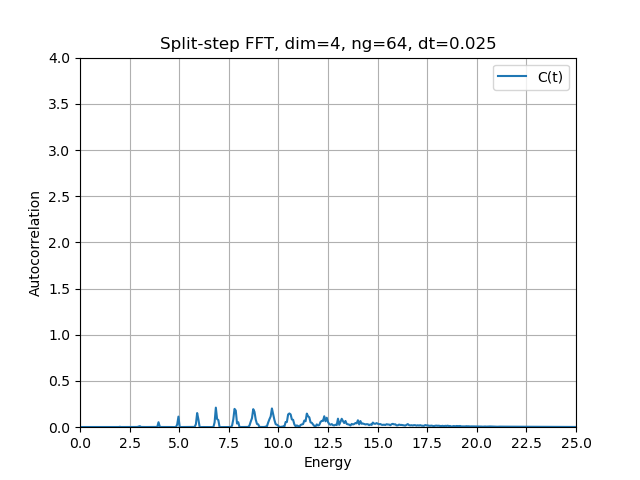

In [41]:
%matplotlib widget
plt.close('all')
plt.figure()
smoothing = 0
#window = np.hamming(len(sim.t_grid))
window = np.cos(np.linspace(0, np.pi/2, len(sim.t_grid)))
#window = np.ones(len(sim.t_grid))

# apply window to autocorrelation
fourier_acorr = np.fft.fftshift(
    np.fft.ifft(acorr * window * np.exp(-sim.t_grid*smoothing) )
).real  / np.pi *  t_final / 2
# fourier_acorr1 = (2*np.pi)**.5 * np.fft.fftshift(
#     np.fft.ifft(acorr * window / (norms**.5) * np.exp(-sim.t_grid*smoothing), norm='ortho'  )
# )
omega = np.fft.fftshift(np.fft.fftfreq(len(sim.t_grid), sim.dt)) * 2 * np.pi

# fourier_acorr2 = (2*np.pi)**.5 * 2*np.fft.fftshift(
#     np.fft.ifft(acorr2 * window * np.exp(-sim.t_grid*smoothing*2) , norm='ortho' )
# )
# omega2 = np.fft.fftshift(np.fft.fftfreq(len(sim.t_grid), sim.dt)) * np.pi

plt.plot(omega, np.abs(fourier_acorr), label='C(t)')
#plt.plot(omega, np.abs(fourier_acorr1), label='C(t) normalized')
#plt.plot(omega2, np.abs(fourier_acorr2), label='C(2t)')
if dim == 2:
    plt.xlim(0, 15)
elif dim == 3:
    plt.xlim(0, 20)
elif dim == 4:
    plt.xlim(0, 25)
plt.ylim(0, 4)
plt.xlabel('Energy')
plt.ylabel('Autocorrelation')
plt.grid('on', which='both')
# set grid spacing to 2.5
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(2.5))

plt.title(f'Split-step FFT, dim={dim}, ng={nx}, dt={sim.dt}')

# if dim == 4:
#     # plot the Worth-Burghardt result if dim=4
#     x, y = np.loadtxt('worth_burghardt_dim_4_hehe_grid.csv', delimiter=',', unpack=True)
#     y = y / 10
#     plt.plot(x, y, label='Worth-Burghardt', zorder=0)

plt.legend()
plt.show()
plt.savefig(f'autocorrelation_{dim}_ng{nx}_dt{sim.dt}.png')


# save the autocorrelation to an npz file
np.savez(f'hehe_split_step_fourier_acorr_dim_{dim}_xmax_{x_max}_ng_{nx}_dt_{sim.dt}.npz', omega=omega, acorr=acorr, acorr2=acorr2, t_grid = sim.t_grid, norms=norms)




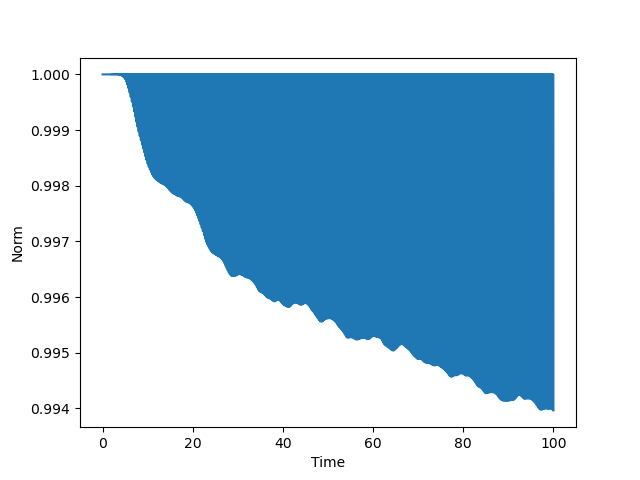

In [42]:
# plot the norms
plt.figure()
plt.plot(sim.t_grid, norms)
plt.xlabel('Time')
plt.ylabel('Norm')
plt.show()
plt.savefig(f'norm_{dim}_ng{nx}_dt{sim.dt}.png')


In [17]:
np.sum(fourier_acorr) * (omega[1] - omega[0])

0.9999138927547025

In [196]:
dt

0.025

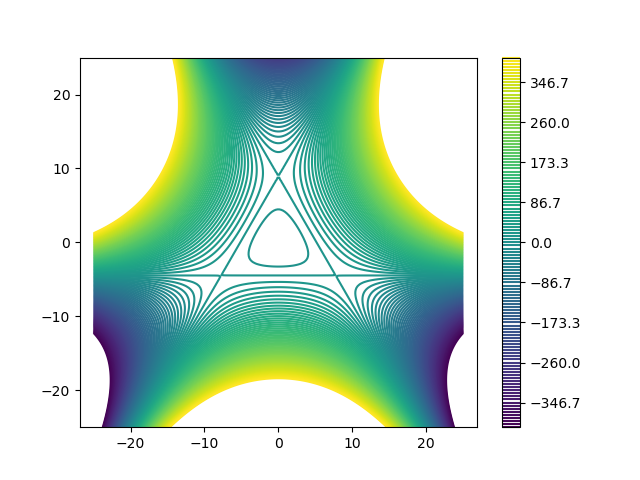

In [33]:
def plot_potential():
    ell = (1/80)**.5
    x, y = np.meshgrid(np.linspace(-25, 25,200), np.linspace(-25,25,200))
    z = potential2(x, y, ell = ell )
    
    plt.figure()
    # plot countour plot of potential, include 1/(6*ell**2).
    plt.contour(x, y, z, levels=np.linspace(-30/(6*ell**2), 30/(6*ell**2), 120+1), cmap='viridis')
    plt.colorbar()
    
    plt.axis('equal')
    plt.show()
plot_potential()
